# Robustness Analysis: Multiplicative vs Additive Errors

This notebook compares the effectiveness of the toggling-frame robustness objective for both multiplicative and additive errors. It's strucuted as follows:
* Imports & Setup
* Unitary Smooth Pulse Problem: Here we compare the effect of the toggling frame robustness objective on additive and multiplicative errors without any variational states.
* Unitary Variational Pulse Problem: Adjoint, Toggling, Adjoint + Toggling Comparison: Here we compare the effect of the toggling frame robustness relative to the existing adjoint robustness objective on both additive and multiplicative errors (with variational states)

## Imports

In [12]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
   Resolving package versions...
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Manifest.toml`


In [14]:
# Problem parameters
T = 50
Δt = 0.5
U_goal = GATES.X
H_drive = PAULIS.X
rob_scale = 1 / 8.0
a_bound = 0.2
dda_bound = 0.1
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);

In [15]:
# setup problems
H_drive_add = H_drive
∂ₑHₐ = H_drive

sys = QuantumSystem([H_drive])

varsys_add = VariationalQuantumSystem(
    [H_drive_add],
    [∂ₑHₐ]
)

H_drive_m = a -> a[1] * H_drive
H_vars_array = Function[H_drive_m]

varsys_mult = VariationalQuantumSystem(
    H_vars_array[1],
    H_vars_array,
    1
)

H_drive_b = a -> a[1] * H_drive + H_drive
# H_drift_a = a -> H_drive
H_vars_b_array = Function[H_drive_b]

varsys_both = VariationalQuantumSystem(
    H_vars_b_array[1],
    H_vars_b_array,
    1
)

VariationalQuantumSystem: levels = 2, n_drives = 1

In [5]:
default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; Q_t=1.0)
solve!(default, max_iter=150, print_level=5)
    
add_prob = UnitaryVariationalProblem(
        varsys_add, U_goal, T, Δt;
        variational_scales=[rob_scale],
        robust_times=[[T]],
        piccolo_options=piccolo_opts,
        Q_t=1.0
    )
solve!(add_prob, max_iter=100, print_level=5)


mult_prob = UnitaryVariationalProblem(
        varsys_mult, U_goal, T, Δt;
        variational_scales=[rob_scale],
        robust_times=[[T]],
        piccolo_options=piccolo_opts,
        Q_t=1.0
    )
solve!(mult_prob, max_iter=100, print_level=5)


both_prob = UnitaryVariationalProblem(
        varsys_both, U_goal, T, Δt;
        variational_scales=[rob_scale],
        robust_times=[[T]],
        piccolo_options=piccolo_opts,
        Q_t=1.0
    )
solve!(both_prob, max_iter=100, print_level=5)

    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:     4728
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1669

Total number of variables............................:      590
                     variables with only lower bounds:        0
                variables with 

In [9]:
rob_default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; activate_rob_loss=true, H_err=H_drive, Q_t=1.0)
solve!(rob_default, max_iter=150, print_level=5)

add_rob_prob = UnitaryVariationalProblem(
        varsys_add, U_goal, T, Δt;
        variational_scales=[rob_scale],
        robust_times=[[T]],
        activate_rob_loss=true,
        H_err=H_drive,
        Q_t=1.0,
        piccolo_options=piccolo_opts
    )
solve!(add_rob_prob, max_iter=100, print_level=5)


mult_rob_prob = UnitaryVariationalProblem(
        varsys_mult, U_goal, T, Δt;
        variational_scales=[rob_scale],
        robust_times=[[T]],
        activate_rob_loss=true,
        H_err=H_drive,
        Q_t=1.0,
        piccolo_options=piccolo_opts
    )
solve!(mult_rob_prob, max_iter=100, print_level=5)


both_rob_prob = UnitaryVariationalProblem(
        varsys_both, U_goal, T, Δt;
        variational_scales=[rob_scale],
        robust_times=[[T]],
        activate_rob_loss=true,
        H_err=H_drive,
        Q_t=1.0,
        piccolo_options=piccolo_opts
    )
solve!(both_rob_prob, max_iter=100, print_level=5)

    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:     4728
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   155333

Total number of variables............................:      590
                     variables with only lower bounds:        0
                variables with 

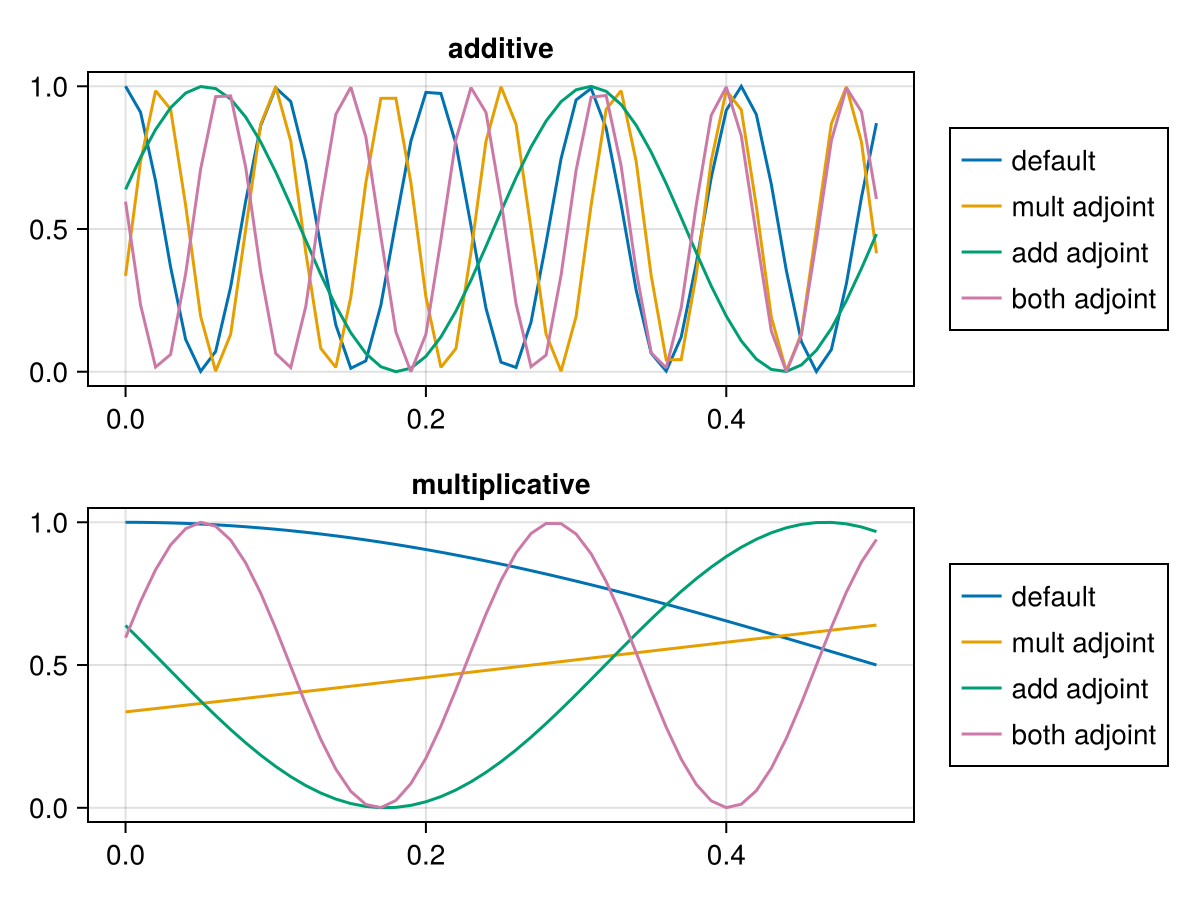

In [22]:
H_drive_add = H_drive

f = Figure()
ax1 = Axis(f[1, 1], title="additive")
ax2 = Axis(f[2, 1], title="multiplicative")

colors = Makie.wong_colors()

εs = 0:0.01:.5

# default case (smooth, non-variational, w/o toggling obj)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(ε * (H_drive), [H_drive_add])) for ε in εs]
lines!(ax1, εs, ys, label="default", color=colors[1], linestyle=:solid)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem([(1 + ε) * H_drive])) for ε in εs]
lines!(ax2, εs, ys, label="default", color=colors[1], linestyle=:solid)

# adjoint-only (no toggling obj)

# (mult)
ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem(ε * (H_drive), [H_drive_add])) for ε in εs]
lines!(ax1, εs, ys, label="mult adjoint", color=colors[2], linestyle=:solid)

ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem([(1 + ε) * H_drive])) for ε in εs]
lines!(ax2, εs, ys, label="mult adjoint", color=colors[2], linestyle=:solid)

# (add)
ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem(ε * (H_drive), [H_drive_add])) for ε in εs]
lines!(ax1, εs, ys, label="add adjoint", color=colors[3], linestyle=:solid)

ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem([(1 + ε) * H_drive])) for ε in εs]
lines!(ax2, εs, ys, label="add adjoint", color=colors[3], linestyle=:solid)

# (both)
ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem(ε * (H_drive), [H_drive_add])) for ε in εs]
lines!(ax1, εs, ys, label="both adjoint", color=colors[4], linestyle=:solid)

ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem([(1 + ε) * H_drive])) for ε in εs]
lines!(ax2, εs, ys, label="both adjoint", color=colors[4], linestyle=:solid)



Legend(f[1,2], ax1, position=:lb)
Legend(f[2,2], ax2, position=:lb)

f


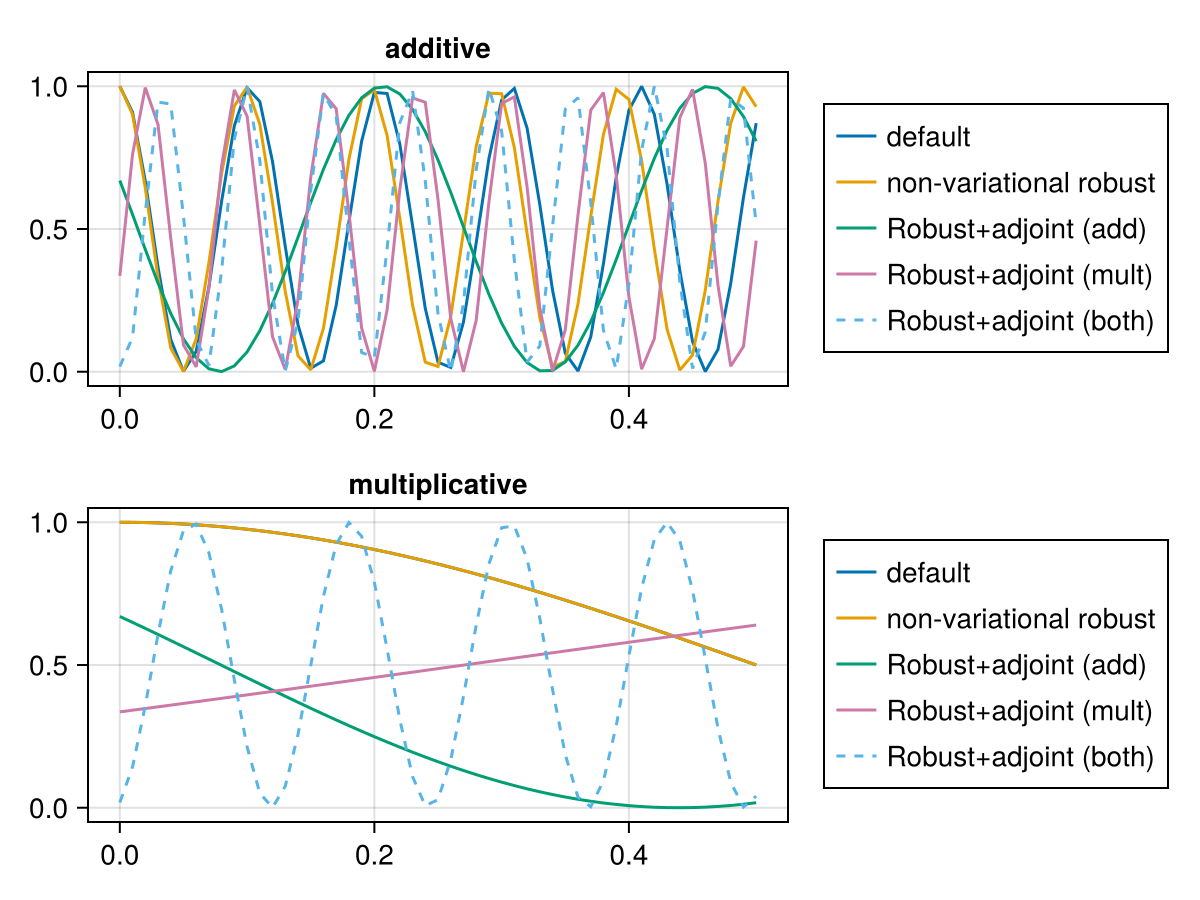

In [ ]:
H_drive_add = H_drive

f = Figure()
ax1 = Axis(f[1, 1], title="additive")
ax2 = Axis(f[2, 1], title="multiplicative")

colors = Makie.wong_colors()

εs = 0:0.01:.5

# default case (smooth, non-variational, w/o toggling obj)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(ε * (H_drive), [H_drive_add])) for ε in εs]
lines!(ax1, εs, ys, label="default", color=colors[1], linestyle=:solid)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem([(1 + ε) * H_drive])) for ε in εs]
lines!(ax2, εs, ys, label="default", color=colors[1], linestyle=:solid)


# toggling-obj-only (no variational states)

ys = [unitary_rollout_fidelity(rob_default.trajectory, QuantumSystem(ε * (H_drive), [H_drive_add])) for ε in εs]
lines!(ax1, εs, ys, label="non-variational robust", color=colors[2], linestyle=:solid)

ys = [unitary_rollout_fidelity(rob_default.trajectory, QuantumSystem([(1 + ε) * H_drive])) for ε in εs]
lines!(ax2, εs, ys, label="non-variational robust", color=colors[2], linestyle=:solid)

# Robust+adjoint (addtive)

ys = [unitary_rollout_fidelity(add_rob_prob.trajectory, QuantumSystem(ε * (H_drive), [H_drive_add])) for ε in εs]
lines!(ax1, εs, ys, label="Robust+adjoint (add)", color=colors[3], linestyle=:solid)

ys = [unitary_rollout_fidelity(add_rob_prob.trajectory, QuantumSystem([(1 + ε) * H_drive])) for ε in εs]
lines!(ax2, εs, ys, label="Robust+adjoint (add)", color=colors[3], linestyle=:solid)

# Robust+adjoint (mult)
ys = [unitary_rollout_fidelity(mult_rob_prob.trajectory, QuantumSystem(ε * (H_drive), [H_drive_add])) for ε in εs]
lines!(ax1, εs, ys, label="Robust+adjoint (mult)", color=colors[4], linestyle=:solid)

ys = [unitary_rollout_fidelity(mult_rob_prob.trajectory, QuantumSystem([(1 + ε) * H_drive])) for ε in εs]
lines!(ax2, εs, ys, label="Robust+adjoint (mult)", color=colors[4], linestyle=:solid)

# Robust+adjoint (both)
ys = [unitary_rollout_fidelity(both_rob_prob.trajectory, QuantumSystem(ε * (H_drive), [H_drive_add])) for ε in εs]
lines!(ax1, εs, ys, label="Robust+adjoint (both)", color=colors[5], linestyle=:dash)

ys = [unitary_rollout_fidelity(both_rob_prob.trajectory, QuantumSystem([(1 + ε) * H_drive])) for ε in εs]
lines!(ax2, εs, ys, label="Robust+adjoint (both)", color=colors[5], linestyle=:dash)


Legend(f[1,2], ax1, position=:lb)
Legend(f[2,2], ax2, position=:lb)

f